# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

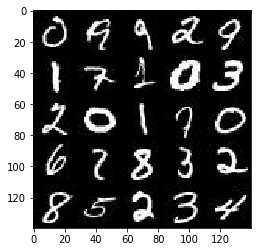

In [38]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

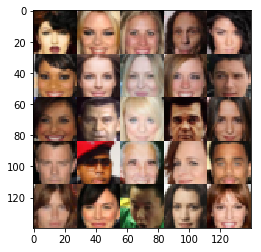

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [44]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, *(image_width, image_height, image_channels)), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [67]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # input layer is 28, 28, 3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x256
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x512
        
        x4 = tf.layers.conv2d(relu3, 1024, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        # 2x2x1024
        
        flat = tf.reshape(relu4, (-1, 2*2*1024))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [66]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=(not is_train)):
        x1 = tf.layers.dense(z, 2*2*1024)
        x1 = tf.reshape(x1, (-1, 2, 2, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x1024
        
        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 4x4x512
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 4, strides=1, padding='valid')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 7x7x256
        
        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [55]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth))
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake))
    )
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake))
    )
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [56]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [57]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [68]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    samples, losses = [], []
    steps = 0
    
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5778... Generator Loss: 2.6846
Epoch 1/2... Discriminator Loss: 3.8040... Generator Loss: 12.5592
Epoch 1/2... Discriminator Loss: 0.4228... Generator Loss: 5.1153
Epoch 1/2... Discriminator Loss: 2.5859... Generator Loss: 10.6365
Epoch 1/2... Discriminator Loss: 0.7870... Generator Loss: 1.0588
Epoch 1/2... Discriminator Loss: 1.3508... Generator Loss: 0.4895
Epoch 1/2... Discriminator Loss: 0.4861... Generator Loss: 2.4938
Epoch 1/2... Discriminator Loss: 1.7270... Generator Loss: 3.5008
Epoch 1/2... Discriminator Loss: 0.8385... Generator Loss: 1.0365
Epoch 1/2... Discriminator Loss: 0.5852... Generator Loss: 2.9287


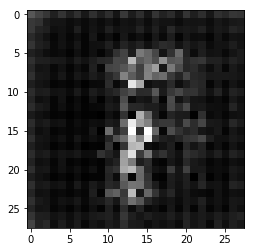

Epoch 1/2... Discriminator Loss: 0.5433... Generator Loss: 1.7816
Epoch 1/2... Discriminator Loss: 0.5079... Generator Loss: 2.5692
Epoch 1/2... Discriminator Loss: 0.4790... Generator Loss: 2.5126
Epoch 1/2... Discriminator Loss: 0.4281... Generator Loss: 2.5261
Epoch 1/2... Discriminator Loss: 1.0430... Generator Loss: 3.7301
Epoch 1/2... Discriminator Loss: 3.3181... Generator Loss: 0.0606
Epoch 1/2... Discriminator Loss: 1.4093... Generator Loss: 5.3894
Epoch 1/2... Discriminator Loss: 0.6292... Generator Loss: 5.0209
Epoch 1/2... Discriminator Loss: 0.6333... Generator Loss: 1.8938
Epoch 1/2... Discriminator Loss: 0.6207... Generator Loss: 2.6595


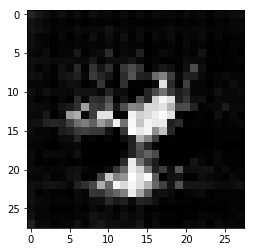

Epoch 1/2... Discriminator Loss: 0.7810... Generator Loss: 3.4132
Epoch 1/2... Discriminator Loss: 1.0263... Generator Loss: 2.6312
Epoch 1/2... Discriminator Loss: 1.3607... Generator Loss: 0.8933
Epoch 1/2... Discriminator Loss: 0.7516... Generator Loss: 5.4013
Epoch 1/2... Discriminator Loss: 0.7584... Generator Loss: 2.1104
Epoch 1/2... Discriminator Loss: 0.9196... Generator Loss: 5.4471
Epoch 1/2... Discriminator Loss: 0.8441... Generator Loss: 2.7297
Epoch 1/2... Discriminator Loss: 1.3559... Generator Loss: 0.5774
Epoch 1/2... Discriminator Loss: 0.7733... Generator Loss: 4.7790
Epoch 1/2... Discriminator Loss: 0.5963... Generator Loss: 1.7810


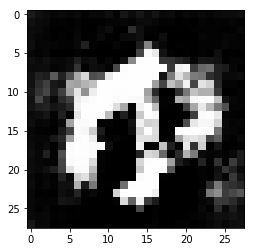

Epoch 1/2... Discriminator Loss: 0.8311... Generator Loss: 5.5253
Epoch 1/2... Discriminator Loss: 0.4612... Generator Loss: 3.9349
Epoch 1/2... Discriminator Loss: 0.5533... Generator Loss: 2.4740
Epoch 1/2... Discriminator Loss: 1.0029... Generator Loss: 4.5807
Epoch 1/2... Discriminator Loss: 0.8460... Generator Loss: 1.2254
Epoch 1/2... Discriminator Loss: 0.8440... Generator Loss: 1.1189
Epoch 1/2... Discriminator Loss: 0.6189... Generator Loss: 2.4467
Epoch 1/2... Discriminator Loss: 0.5333... Generator Loss: 1.8833
Epoch 1/2... Discriminator Loss: 0.8916... Generator Loss: 4.3246
Epoch 1/2... Discriminator Loss: 0.4333... Generator Loss: 2.8253


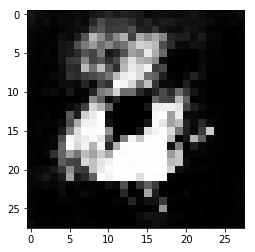

Epoch 1/2... Discriminator Loss: 1.2747... Generator Loss: 7.9460
Epoch 1/2... Discriminator Loss: 0.5905... Generator Loss: 2.5186
Epoch 1/2... Discriminator Loss: 0.9211... Generator Loss: 2.1469
Epoch 1/2... Discriminator Loss: 2.7731... Generator Loss: 6.6263
Epoch 1/2... Discriminator Loss: 0.5567... Generator Loss: 2.7363
Epoch 1/2... Discriminator Loss: 1.3804... Generator Loss: 5.9531
Epoch 1/2... Discriminator Loss: 1.4506... Generator Loss: 4.4464
Epoch 1/2... Discriminator Loss: 0.6626... Generator Loss: 2.8664
Epoch 1/2... Discriminator Loss: 0.4882... Generator Loss: 2.8947
Epoch 1/2... Discriminator Loss: 0.5145... Generator Loss: 2.3400


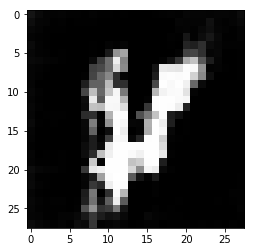

Epoch 1/2... Discriminator Loss: 0.5721... Generator Loss: 2.8974
Epoch 1/2... Discriminator Loss: 0.5609... Generator Loss: 2.0740
Epoch 1/2... Discriminator Loss: 0.5712... Generator Loss: 1.7179
Epoch 1/2... Discriminator Loss: 0.6548... Generator Loss: 1.6104
Epoch 1/2... Discriminator Loss: 0.7276... Generator Loss: 1.5184
Epoch 1/2... Discriminator Loss: 0.6688... Generator Loss: 3.7647
Epoch 1/2... Discriminator Loss: 2.1789... Generator Loss: 8.9475
Epoch 1/2... Discriminator Loss: 0.6398... Generator Loss: 1.5156
Epoch 1/2... Discriminator Loss: 0.7014... Generator Loss: 2.1092
Epoch 1/2... Discriminator Loss: 0.5671... Generator Loss: 1.8016


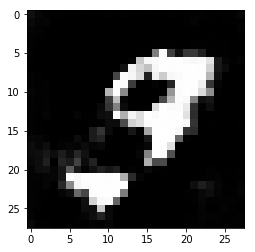

Epoch 1/2... Discriminator Loss: 0.8746... Generator Loss: 4.4771
Epoch 1/2... Discriminator Loss: 0.9408... Generator Loss: 1.1123
Epoch 1/2... Discriminator Loss: 1.0642... Generator Loss: 3.5557
Epoch 1/2... Discriminator Loss: 0.7525... Generator Loss: 1.2327
Epoch 1/2... Discriminator Loss: 0.8657... Generator Loss: 3.1504
Epoch 1/2... Discriminator Loss: 1.3606... Generator Loss: 0.6524
Epoch 1/2... Discriminator Loss: 1.5640... Generator Loss: 6.4292
Epoch 1/2... Discriminator Loss: 1.5244... Generator Loss: 0.4574
Epoch 1/2... Discriminator Loss: 0.5918... Generator Loss: 1.8051
Epoch 1/2... Discriminator Loss: 0.6148... Generator Loss: 2.5513


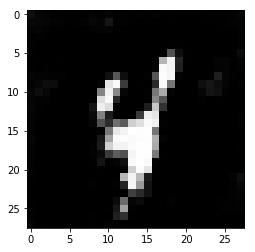

Epoch 1/2... Discriminator Loss: 0.9662... Generator Loss: 1.1056
Epoch 1/2... Discriminator Loss: 1.1223... Generator Loss: 1.2035
Epoch 1/2... Discriminator Loss: 0.6942... Generator Loss: 2.6838
Epoch 1/2... Discriminator Loss: 0.8639... Generator Loss: 0.9984
Epoch 1/2... Discriminator Loss: 1.0566... Generator Loss: 0.9950
Epoch 1/2... Discriminator Loss: 1.1957... Generator Loss: 0.7058
Epoch 1/2... Discriminator Loss: 0.8922... Generator Loss: 3.8352
Epoch 1/2... Discriminator Loss: 1.4622... Generator Loss: 4.7558
Epoch 1/2... Discriminator Loss: 0.7338... Generator Loss: 1.3317
Epoch 1/2... Discriminator Loss: 2.3854... Generator Loss: 6.5971


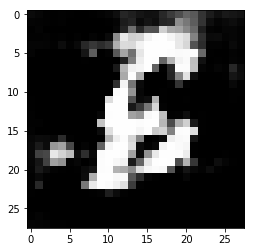

Epoch 1/2... Discriminator Loss: 0.7102... Generator Loss: 2.8458
Epoch 1/2... Discriminator Loss: 1.4779... Generator Loss: 5.0262
Epoch 1/2... Discriminator Loss: 0.6526... Generator Loss: 2.7012
Epoch 1/2... Discriminator Loss: 0.5939... Generator Loss: 2.1388
Epoch 1/2... Discriminator Loss: 0.5287... Generator Loss: 2.8886
Epoch 1/2... Discriminator Loss: 0.8859... Generator Loss: 1.0289
Epoch 1/2... Discriminator Loss: 0.9584... Generator Loss: 0.8477
Epoch 1/2... Discriminator Loss: 2.1010... Generator Loss: 5.8516
Epoch 1/2... Discriminator Loss: 0.7594... Generator Loss: 1.5872
Epoch 1/2... Discriminator Loss: 1.0086... Generator Loss: 0.8296


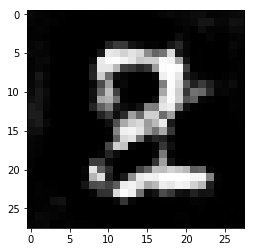

Epoch 1/2... Discriminator Loss: 0.5880... Generator Loss: 2.2099
Epoch 1/2... Discriminator Loss: 0.7890... Generator Loss: 1.1226
Epoch 1/2... Discriminator Loss: 0.9550... Generator Loss: 0.8636
Epoch 2/2... Discriminator Loss: 0.9502... Generator Loss: 1.8916
Epoch 2/2... Discriminator Loss: 0.9507... Generator Loss: 2.1911
Epoch 2/2... Discriminator Loss: 1.0263... Generator Loss: 0.9035
Epoch 2/2... Discriminator Loss: 1.0699... Generator Loss: 3.0630
Epoch 2/2... Discriminator Loss: 0.7869... Generator Loss: 1.3619
Epoch 2/2... Discriminator Loss: 0.9586... Generator Loss: 2.2044
Epoch 2/2... Discriminator Loss: 0.9717... Generator Loss: 1.3555


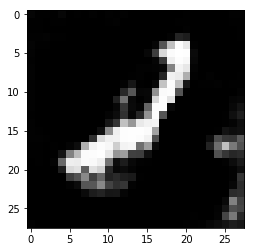

Epoch 2/2... Discriminator Loss: 2.5684... Generator Loss: 3.8487
Epoch 2/2... Discriminator Loss: 1.1194... Generator Loss: 0.6872
Epoch 2/2... Discriminator Loss: 1.0498... Generator Loss: 0.8332
Epoch 2/2... Discriminator Loss: 1.6120... Generator Loss: 0.3813
Epoch 2/2... Discriminator Loss: 1.0861... Generator Loss: 1.9153
Epoch 2/2... Discriminator Loss: 0.8549... Generator Loss: 1.4231
Epoch 2/2... Discriminator Loss: 1.0583... Generator Loss: 0.7467
Epoch 2/2... Discriminator Loss: 0.7320... Generator Loss: 1.3544
Epoch 2/2... Discriminator Loss: 1.5396... Generator Loss: 0.4700
Epoch 2/2... Discriminator Loss: 1.3502... Generator Loss: 0.5245


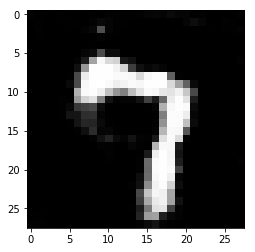

Epoch 2/2... Discriminator Loss: 1.2351... Generator Loss: 0.5891
Epoch 2/2... Discriminator Loss: 1.1685... Generator Loss: 0.6883
Epoch 2/2... Discriminator Loss: 1.1274... Generator Loss: 2.1461
Epoch 2/2... Discriminator Loss: 0.9244... Generator Loss: 1.2073
Epoch 2/2... Discriminator Loss: 1.7092... Generator Loss: 0.4227
Epoch 2/2... Discriminator Loss: 0.8920... Generator Loss: 1.0797
Epoch 2/2... Discriminator Loss: 1.3214... Generator Loss: 3.1040
Epoch 2/2... Discriminator Loss: 0.8610... Generator Loss: 1.0633
Epoch 2/2... Discriminator Loss: 2.3354... Generator Loss: 0.1794
Epoch 2/2... Discriminator Loss: 0.9137... Generator Loss: 0.9020


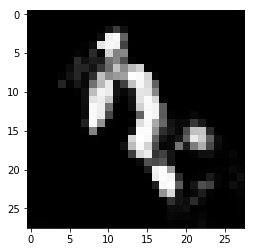

Epoch 2/2... Discriminator Loss: 0.9844... Generator Loss: 0.8889
Epoch 2/2... Discriminator Loss: 1.4070... Generator Loss: 0.4776
Epoch 2/2... Discriminator Loss: 1.0314... Generator Loss: 0.8767
Epoch 2/2... Discriminator Loss: 0.8941... Generator Loss: 1.8667
Epoch 2/2... Discriminator Loss: 2.9443... Generator Loss: 3.9860
Epoch 2/2... Discriminator Loss: 1.0136... Generator Loss: 1.3404
Epoch 2/2... Discriminator Loss: 1.1500... Generator Loss: 2.8247
Epoch 2/2... Discriminator Loss: 1.0715... Generator Loss: 0.8272
Epoch 2/2... Discriminator Loss: 0.6914... Generator Loss: 2.1338
Epoch 2/2... Discriminator Loss: 0.7132... Generator Loss: 2.6977


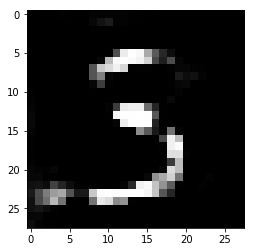

Epoch 2/2... Discriminator Loss: 1.2197... Generator Loss: 0.6013
Epoch 2/2... Discriminator Loss: 1.0194... Generator Loss: 0.8470
Epoch 2/2... Discriminator Loss: 1.5730... Generator Loss: 0.3954
Epoch 2/2... Discriminator Loss: 1.2568... Generator Loss: 0.5729
Epoch 2/2... Discriminator Loss: 1.4782... Generator Loss: 0.5458
Epoch 2/2... Discriminator Loss: 0.8890... Generator Loss: 1.0141
Epoch 2/2... Discriminator Loss: 0.9488... Generator Loss: 0.9357
Epoch 2/2... Discriminator Loss: 1.2773... Generator Loss: 0.6098
Epoch 2/2... Discriminator Loss: 1.3876... Generator Loss: 0.5179
Epoch 2/2... Discriminator Loss: 0.8035... Generator Loss: 1.1885


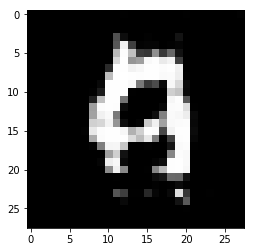

Epoch 2/2... Discriminator Loss: 0.7965... Generator Loss: 1.1174
Epoch 2/2... Discriminator Loss: 0.8371... Generator Loss: 2.7100
Epoch 2/2... Discriminator Loss: 0.7981... Generator Loss: 1.3732
Epoch 2/2... Discriminator Loss: 4.6960... Generator Loss: 7.3152
Epoch 2/2... Discriminator Loss: 1.3858... Generator Loss: 0.4978
Epoch 2/2... Discriminator Loss: 0.9249... Generator Loss: 0.9632
Epoch 2/2... Discriminator Loss: 1.4896... Generator Loss: 0.4287
Epoch 2/2... Discriminator Loss: 1.1006... Generator Loss: 0.7737
Epoch 2/2... Discriminator Loss: 1.9830... Generator Loss: 0.3007
Epoch 2/2... Discriminator Loss: 1.0331... Generator Loss: 0.9118


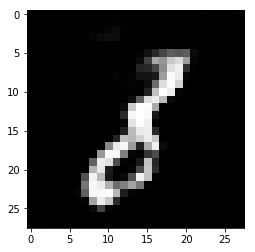

Epoch 2/2... Discriminator Loss: 1.3734... Generator Loss: 0.5229
Epoch 2/2... Discriminator Loss: 0.9911... Generator Loss: 0.9134
Epoch 2/2... Discriminator Loss: 0.7478... Generator Loss: 1.6485
Epoch 2/2... Discriminator Loss: 0.9204... Generator Loss: 0.9996
Epoch 2/2... Discriminator Loss: 1.1540... Generator Loss: 0.6486
Epoch 2/2... Discriminator Loss: 0.8900... Generator Loss: 1.0989
Epoch 2/2... Discriminator Loss: 0.9324... Generator Loss: 0.8922
Epoch 2/2... Discriminator Loss: 0.8655... Generator Loss: 1.0162
Epoch 2/2... Discriminator Loss: 1.6291... Generator Loss: 0.5104
Epoch 2/2... Discriminator Loss: 0.8973... Generator Loss: 1.0146


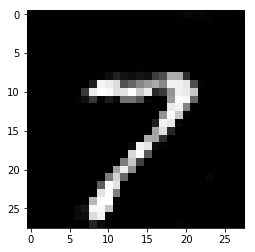

Epoch 2/2... Discriminator Loss: 1.1065... Generator Loss: 0.8265
Epoch 2/2... Discriminator Loss: 0.8393... Generator Loss: 1.0322
Epoch 2/2... Discriminator Loss: 0.7521... Generator Loss: 1.3181
Epoch 2/2... Discriminator Loss: 1.6102... Generator Loss: 4.4711
Epoch 2/2... Discriminator Loss: 0.8856... Generator Loss: 0.9623
Epoch 2/2... Discriminator Loss: 0.6967... Generator Loss: 1.6018
Epoch 2/2... Discriminator Loss: 1.1116... Generator Loss: 0.7439
Epoch 2/2... Discriminator Loss: 0.6138... Generator Loss: 1.8197
Epoch 2/2... Discriminator Loss: 1.3121... Generator Loss: 0.6489
Epoch 2/2... Discriminator Loss: 0.9631... Generator Loss: 1.9287


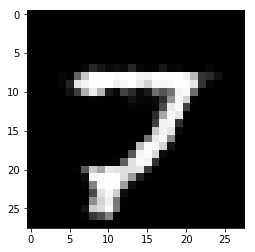

Epoch 2/2... Discriminator Loss: 0.8930... Generator Loss: 0.9963
Epoch 2/2... Discriminator Loss: 1.1171... Generator Loss: 0.7151
Epoch 2/2... Discriminator Loss: 0.7370... Generator Loss: 2.4199
Epoch 2/2... Discriminator Loss: 0.9499... Generator Loss: 0.8744
Epoch 2/2... Discriminator Loss: 0.5179... Generator Loss: 2.1175
Epoch 2/2... Discriminator Loss: 0.7341... Generator Loss: 1.5962
Epoch 2/2... Discriminator Loss: 0.7910... Generator Loss: 1.1783
Epoch 2/2... Discriminator Loss: 0.7491... Generator Loss: 1.3796
Epoch 2/2... Discriminator Loss: 0.7555... Generator Loss: 1.3364
Epoch 2/2... Discriminator Loss: 0.9862... Generator Loss: 1.0744


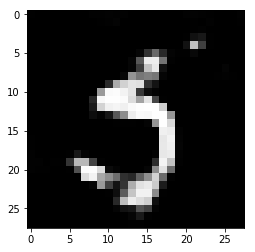

Epoch 2/2... Discriminator Loss: 1.1954... Generator Loss: 0.8530
Epoch 2/2... Discriminator Loss: 0.9285... Generator Loss: 0.9275
Epoch 2/2... Discriminator Loss: 0.8905... Generator Loss: 1.0019
Epoch 2/2... Discriminator Loss: 0.7660... Generator Loss: 2.4362
Epoch 2/2... Discriminator Loss: 0.6603... Generator Loss: 1.6684
Epoch 2/2... Discriminator Loss: 0.8621... Generator Loss: 2.1525
Epoch 2/2... Discriminator Loss: 1.8353... Generator Loss: 0.3571


In [70]:
batch_size = 64
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0737... Generator Loss: 0.9814
Epoch 1/1... Discriminator Loss: 0.3867... Generator Loss: 4.1505
Epoch 1/1... Discriminator Loss: 0.4025... Generator Loss: 4.8572
Epoch 1/1... Discriminator Loss: 0.4424... Generator Loss: 5.7653
Epoch 1/1... Discriminator Loss: 0.3627... Generator Loss: 3.8878
Epoch 1/1... Discriminator Loss: 3.6676... Generator Loss: 0.0481
Epoch 1/1... Discriminator Loss: 2.5153... Generator Loss: 6.1401
Epoch 1/1... Discriminator Loss: 0.4285... Generator Loss: 2.8176
Epoch 1/1... Discriminator Loss: 4.5202... Generator Loss: 0.0170
Epoch 1/1... Discriminator Loss: 0.4045... Generator Loss: 3.5158


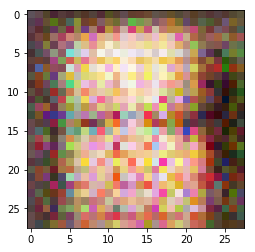

Epoch 1/1... Discriminator Loss: 0.6724... Generator Loss: 1.7351
Epoch 1/1... Discriminator Loss: 0.4926... Generator Loss: 2.0765
Epoch 1/1... Discriminator Loss: 1.7593... Generator Loss: 2.7472
Epoch 1/1... Discriminator Loss: 1.5457... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.4945... Generator Loss: 0.5179
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 1.3514
Epoch 1/1... Discriminator Loss: 1.5688... Generator Loss: 0.4287
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.8746... Generator Loss: 3.3263
Epoch 1/1... Discriminator Loss: 0.8814... Generator Loss: 1.1233


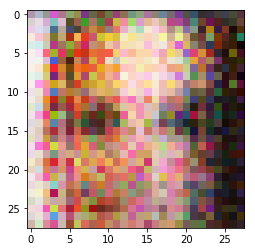

Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 1.8878
Epoch 1/1... Discriminator Loss: 1.5788... Generator Loss: 0.4201
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.6244... Generator Loss: 0.3779
Epoch 1/1... Discriminator Loss: 0.9618... Generator Loss: 1.1497
Epoch 1/1... Discriminator Loss: 1.1065... Generator Loss: 2.2205
Epoch 1/1... Discriminator Loss: 1.0144... Generator Loss: 1.3035
Epoch 1/1... Discriminator Loss: 1.0402... Generator Loss: 1.1148
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 1.4561
Epoch 1/1... Discriminator Loss: 1.0068... Generator Loss: 0.9092


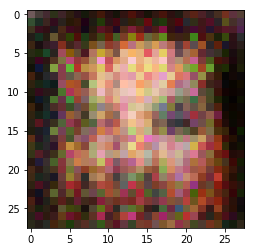

Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 2.1886
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 1.0100
Epoch 1/1... Discriminator Loss: 2.4793... Generator Loss: 0.1526
Epoch 1/1... Discriminator Loss: 1.0047... Generator Loss: 1.1428
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 2.2247
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 1.0185
Epoch 1/1... Discriminator Loss: 1.1284... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 1.3052
Epoch 1/1... Discriminator Loss: 1.2790... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 1.8470


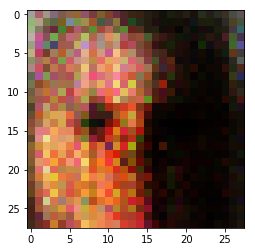

Epoch 1/1... Discriminator Loss: 0.9254... Generator Loss: 1.7442
Epoch 1/1... Discriminator Loss: 0.9487... Generator Loss: 1.1311
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 1.9870
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 1.2042
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 1.7314
Epoch 1/1... Discriminator Loss: 0.9421... Generator Loss: 1.1506
Epoch 1/1... Discriminator Loss: 1.6473... Generator Loss: 3.1444
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.6843... Generator Loss: 3.9679
Epoch 1/1... Discriminator Loss: 0.9807... Generator Loss: 0.8576


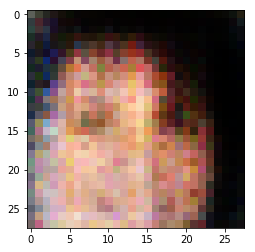

Epoch 1/1... Discriminator Loss: 1.9083... Generator Loss: 0.2733
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 1.3453
Epoch 1/1... Discriminator Loss: 0.9454... Generator Loss: 1.2181
Epoch 1/1... Discriminator Loss: 0.9927... Generator Loss: 1.3917
Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 1.0829... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 0.9001... Generator Loss: 1.9017
Epoch 1/1... Discriminator Loss: 2.9508... Generator Loss: 0.0987
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 0.9788


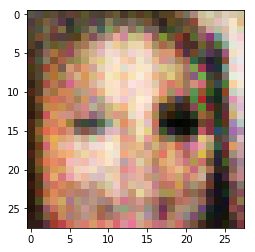

Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 1.6838
Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 2.8212
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.5632
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 2.7759
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.5206
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 1.3959
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 2.3747
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 2.7006
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.5541... Generator Loss: 2.6933


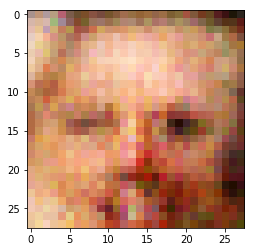

Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 2.7029
Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.8180... Generator Loss: 0.2975
Epoch 1/1... Discriminator Loss: 1.0501... Generator Loss: 1.1971
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.5908
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 1.4092
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.5140
Epoch 1/1... Discriminator Loss: 1.5453... Generator Loss: 2.3956
Epoch 1/1... Discriminator Loss: 1.6585... Generator Loss: 0.3542


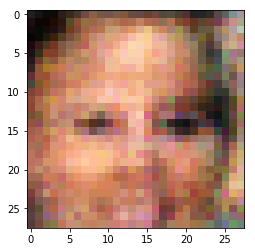

Epoch 1/1... Discriminator Loss: 1.2378... Generator Loss: 0.6032
Epoch 1/1... Discriminator Loss: 0.8889... Generator Loss: 1.2720
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.8627
Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 0.5443
Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 0.9802... Generator Loss: 0.8134
Epoch 1/1... Discriminator Loss: 1.0590... Generator Loss: 1.7537
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.0342... Generator Loss: 1.0614
Epoch 1/1... Discriminator Loss: 1.2738... Generator Loss: 0.6276


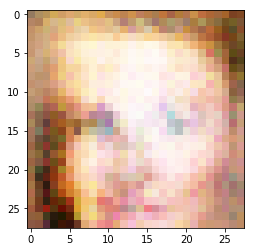

Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 1.0751
Epoch 1/1... Discriminator Loss: 0.9569... Generator Loss: 2.0350
Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 1.5571
Epoch 1/1... Discriminator Loss: 1.0035... Generator Loss: 0.8617
Epoch 1/1... Discriminator Loss: 0.8145... Generator Loss: 1.1608
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.4804
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 0.8517... Generator Loss: 1.5057


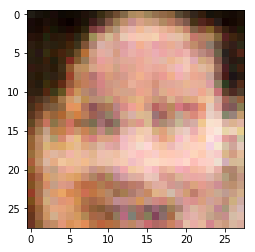

Epoch 1/1... Discriminator Loss: 0.7847... Generator Loss: 1.3879
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 1.4518
Epoch 1/1... Discriminator Loss: 0.7339... Generator Loss: 1.2692
Epoch 1/1... Discriminator Loss: 1.5433... Generator Loss: 0.3917
Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 0.9996
Epoch 1/1... Discriminator Loss: 1.9218... Generator Loss: 0.2453
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 1.5845
Epoch 1/1... Discriminator Loss: 0.9344... Generator Loss: 0.9055
Epoch 1/1... Discriminator Loss: 0.8913... Generator Loss: 2.1114
Epoch 1/1... Discriminator Loss: 1.0174... Generator Loss: 2.8909


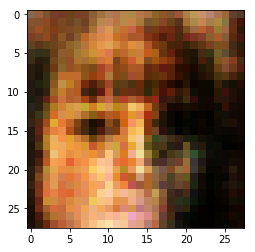

Epoch 1/1... Discriminator Loss: 1.1162... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 1.0044
Epoch 1/1... Discriminator Loss: 0.9816... Generator Loss: 2.4859
Epoch 1/1... Discriminator Loss: 0.9422... Generator Loss: 0.9124
Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 0.7667... Generator Loss: 1.8302
Epoch 1/1... Discriminator Loss: 1.9404... Generator Loss: 3.2431
Epoch 1/1... Discriminator Loss: 0.7268... Generator Loss: 1.5668
Epoch 1/1... Discriminator Loss: 0.5625... Generator Loss: 1.7438
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.4962


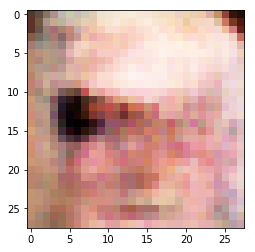

Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 0.9252
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 0.5165
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 1.8409
Epoch 1/1... Discriminator Loss: 0.9633... Generator Loss: 0.9365
Epoch 1/1... Discriminator Loss: 0.7605... Generator Loss: 1.1325
Epoch 1/1... Discriminator Loss: 0.9400... Generator Loss: 1.1973
Epoch 1/1... Discriminator Loss: 1.0564... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.4565
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 0.6021


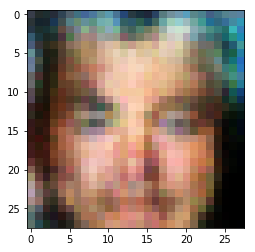

Epoch 1/1... Discriminator Loss: 1.0591... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.9574... Generator Loss: 0.2507
Epoch 1/1... Discriminator Loss: 2.0153... Generator Loss: 3.8427
Epoch 1/1... Discriminator Loss: 0.9256... Generator Loss: 1.9495
Epoch 1/1... Discriminator Loss: 0.6564... Generator Loss: 1.7299
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 0.5977
Epoch 1/1... Discriminator Loss: 0.8401... Generator Loss: 1.1377
Epoch 1/1... Discriminator Loss: 1.5422... Generator Loss: 0.4132
Epoch 1/1... Discriminator Loss: 1.5229... Generator Loss: 0.4185
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 3.2402


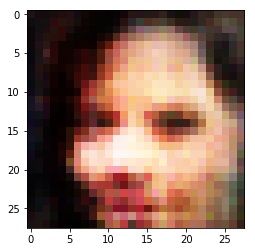

Epoch 1/1... Discriminator Loss: 0.6020... Generator Loss: 1.4981
Epoch 1/1... Discriminator Loss: 0.6267... Generator Loss: 1.4898
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 3.4435
Epoch 1/1... Discriminator Loss: 0.6849... Generator Loss: 1.4317
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 3.2856
Epoch 1/1... Discriminator Loss: 0.9744... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 0.6667... Generator Loss: 1.5849
Epoch 1/1... Discriminator Loss: 0.9110... Generator Loss: 1.4469
Epoch 1/1... Discriminator Loss: 2.7170... Generator Loss: 3.3760


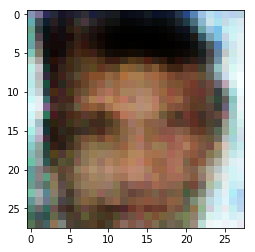

Epoch 1/1... Discriminator Loss: 1.0276... Generator Loss: 1.0137
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.0675... Generator Loss: 1.2914
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 1.3089
Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 0.8841
Epoch 1/1... Discriminator Loss: 0.7951... Generator Loss: 1.1443
Epoch 1/1... Discriminator Loss: 0.9565... Generator Loss: 1.9312
Epoch 1/1... Discriminator Loss: 1.8620... Generator Loss: 3.9281


In [71]:
batch_size = 128
z_dim = 500
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.